# PDB - Derived Data and Coordinate
This notebook contains the workflow to download, sanitise and process derived data and coordinates from the PDB. A preliminary selection of PDB entry should also be done through the dataframe in this step. Some descriptive statistics were also done. 


## Exclusion of Pdb Entries


Below eliminate the first three problems
> Df_grandpronuc_selected = Df_grandpronuc.loc[(Df_grandpronuc['Resolution'] <= 3.0) \
                                              & (pd.notnull(Df_grandpronuc['PubmedID'])) \
                                              & (pd.notnull(Df_grandpronuc['InternalSymmetryBC-95'])) \
                                              & ~(Df_grandpronuc["Title"].str.contains('ribos|riboz', regex=True, na=False)) \
                                              & ~(Df_grandpronuc["Header"].str.contains('ribos|riboz', regex=True, na=False))]

> Df_grandprorna_selected = Df_grandpronuc_selected.loc[Df_grandpronuc_selected['NucleicAcid'] == 'rna']

Pdb entries containing modified bases and short peptide/nucleotide are excluded by flags
> SyncPdbData.UpdateDerivedData(PART1_Downloading = True, ExcludeShortPeptideLength = 30, ExcludeShortNucleotideLength = 4, FilterChemicalComponentList = ["1MG","5MC","H2U","5MU","PSU"])

Also note that a few pdbid was superseded by a new pdbid since NucleicNet was born 2019, so the pdbid changed! Examples
> https://www.rcsb.org/structure/4V4F \
> https://www.rcsb.org/structure/5E3H \
> https://www.rcsb.org/structure/4OLA \
> https://www.rcsb.org/structure/4OLB \
> https://www.rcsb.org/structure/4L8R 

## NOTE
A small fraction of categories (i.e. RnaChain, DnaChain, ProteinChain) were retrieved from NPIDB, which maybe easily replaced by analysing the residue names in a chain to drop this dependency.
* 'NpidbClassification', 'DnaChain', 'ProteinChain', 'RnaChain','NucleicAcid' : These are extracted from NPIDB, but 


## Imports and File I/O
This sections define necessary imports and directories

In [1]:
# =================== Imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../')

from NucleicNet.DatasetBuilding import commandSyncPdbData
from NucleicNet.DatasetBuilding.util import *
from NucleicNet.DatasetBuilding.commandReadPdbFtp import ReadBCExternalSymmetry, MakeBcClanGraph


SyncPdbData = commandSyncPdbData.SyncPdbData(
    DerivedDataFolder = "../Database-PDB/DerivedData",
    n_MultiprocessingWorkers = 16, 
    UnzippedPdbFolder = "../Database-PDB/unzipped",
    CleansedPdbFolder = "../Database-PDB/cleansed",
    ApoPdbFolder = "../Database-PDB/apo",
    DsspFolder="../Database-PDB/dssp",
    DsspExecutable="../NucleicNet/util/dssp",
    exclusion = ["pdb_chain_go.lst"]
    )

## Organise Pdb Derived Data
This section downloads and organises derived data available on RCSB FTP. The PDB is updated every [Wednesday 00:00 UTC (Coordinated Universal Time) with new entries, modified entries, and updated status information.](https://www.rcsb.org/pages/faq). The resultant dataframe `../Database-PDB/DerivedData/DataframeGrand.pkl` contains many useful columns; comments follows.


* 'Pdbid','OrganismName', 'OrganismID',  'Authors' : Some very basic info. 
* 'PubmedID','Source', 'Header', 'Title' : These are useful to eliminate e.g. unpublished entries or broad types of protein.
* 'InternalSymmetryBC-95' : This groups chains sharing internal symmetry w/ an underscore
* 'Date' : Time stamp of processing. 
* 'Resolution' : This is useful to eliminate 'low-confidence' data. 
* 'Experiment' : Useful when EM or NMR structures are to be eliminated. 
* 'ProNu' : "prot-nuc" is the NA-bound protein. 

 
Below are some very broad exclusion principles used in NucleicNet to extract some reasonable data. During the training-testing phase, we also strongly recommend users to inspect and report if groups of proteins (w/ strong biological context) can have extremely bad performance or may improve the overall performance of other proteins when they are excluded. Several known cases:
* Disproportionally extensive RNA-RNA interactions or phospho-sugar backbone interactions. Ribosome/ribozymes where the interactions were largely supported by RNA-RNA interactions rather than protein-RNA interactions. Note the DNA are un-inspected as they are out of scope in the first NucleicNet paper.
* Entries deposited but without a peer-reviewed article. Some of those structures are of poor quality in terms of [structure refinement](https://www.wwpdb.org/validation/2017/XrayValidationReportHelp).
* Poor resolution. For example, Cryo-EM structure with poorer than 3.5 angstrom resolution. Important note here is that [sidechain stubbing](http://www.phenix-online.org/pipermail/phenixbb/2011-February/016563.html) is a commonly accepted practice when local resolution is poor.
* Featureless proteins. RNA bound to short protein chain typically less than 50 amino acids in length. Here a margin of 30 is used.
* Short possibly unresolved RNA strand. Proteins bound to Short RNA chains typically less than 4 nucleotides in length. Many of these structures have part of the RNA strand unresolved, also a common practice in the community. 
* Modified base. These are usually "add-ons" to either allow stronger binding w/ a certain protein or may arise naturally in situations such as t-RNA or commonly methylated cytosine. These bases can drastically change the binding preference of NA on a protein e.g. overiding some binding preference in the conventional bases. They also tend to give "false positives" w.r.t. programs that predict conventional bases. The flag `ExcludeChemicalComponentList` excludes entries containing some of these bases.

Also note that freshly indexed PDB entries (within last 2 weeks) may contain incomplete information. Some entries can also contain missing/misplaced PubmedID, though this seldom matter, some of these entries are not accompanied by a publication that we can refer to.

The cell below can take 5-10 minutes to run when `PART1_Downloading = False`, else it can take more than 12 hours to run.




In [2]:
# ================ download pdb ftp derived data
PART0_Derive = False
if PART0_Derive:
    SyncPdbData.UpdateDerivedData(PART1_Downloading = False, 
                              ExcludeShortPeptideLength = 30, 
                              ExcludeShortNucleotideLength = 4,
                              ExcludeChemicalComponentList = ["1MG","5MC","1MA","U37","UFT",
                                                              "SUR","PYO","P5P","OMC","OMG","OMU","ONE",
                                                              "FMU","GTA","CFZ","CFL","AP7","ADN","AZM",
                                                              "A9Z","6MZ","N5M","5BU","2PR","2AD","23G","A23",
                                                              "APC","CGI","PGP","U5P"])
# Other candidates are "CCC" "5MU" "FHU", "H2U","PSU","G3A", but seems too restrictive. 

# =================== Inspections after downloads
Df_grand = pd.read_pickle("../Database-PDB/DerivedData/DataframeGrand.pkl")
Df_grandpronuc = Df_grand.loc[(Df_grand["ProNu"] == "prot-nuc")]
Df_grandpronuc_selected = Df_grandpronuc.loc[(Df_grandpronuc['Resolution'] <= 3.5) # NOTE you may consider to relax the 3.0 Angstron resolution limit as cryoEM structure w/ ~3.5 angstrom are not uncommon to be modelled in full atom these days
#                                              & (pd.notnull(Df_grandpronuc['PubmedID'])) # NOTE some PubMedID become null by the pdb curator
                                              & (pd.notnull(Df_grandpronuc['InternalSymmetryBC-95']))
                                              & ~(Df_grandpronuc["Title"].str.contains('ribosome', regex=True, na=False))
                                              & ~(Df_grandpronuc["Header"].str.contains('ribosome', regex=True, na=False))
                                              & (Df_grand["MeanChainLength_Nucleotide"] > 4) & (Df_grand["SumChainLength_Peptide"] > 50) 
                                              #& (Df_grandpronuc['SumChainLength_All'] <= 5000) 
                                              ]

Df_grandprorna_selected = Df_grandpronuc_selected.loc[Df_grandpronuc_selected['NucleicAcid'] == 'rna']
print("List of columns")
print(Df_grandpronuc.columns)

print("High quality entries (DNA/RNA/Hybrid)")
print(Df_grandpronuc_selected.shape)
print("High quality entries (RNA)")
print(Df_grandprorna_selected.shape)
print("High quality entries (RNA < 2017)")
print(Df_grandprorna_selected.loc[Df_grandprorna_selected['Year'] < 2017].shape)


## Pdb Coordinate Data
This section downloads and, very importantly, sanitise the listed Pdbids. [Biological assembly](https://proteopedia.org/wiki/index.php/Biological_Unit), [Ensemble Models](https://proteopedia.org/wiki/index.php/NMR) and [Alternative locations](https://proteopedia.org/wiki/index.php/Alternate_locations) are handled by the sanitisation procedure `MakeSanitiseCoordinate`. Note while this is parallelised it may still take up to 5-10 minutes for 5000 pdb files for a 16 worker machine w/ SSD for I/O. It does not make sense to machine-learn with unit-cell structures containing extraneous atoms (due to alternative locations) and overlapping atoms (due to ensemble models) for Rna interacting at a un-assembled protein interface. Therefore, sanitisation has to be done with caution. Apo coordinate is made by `MakeApoCoordinate`. Optionally, secondary structures can be outputed as a folder by calling `MakeDssp`.


In [4]:
# ================== Download structure coordinate from PDB

SyncPdbData.UpdateCoordinateData(PdbidList = Df_grandpronuc_selected["Pdbid"].tolist())
SyncPdbData.MakeSanitiseCoordinate()
SyncPdbData.MakeApoCoordinate()
SyncPdbData.MakeDssp()

## Postprocessing of Pdb Ftp

We need to look into the downloaded pdb structure file to determine
* Protein chain in touch with NA (i.e. protein chains within 5 angstrom of any NA atoms). It can take > 10 minutes to run through 5000 entries.

In [7]:
SyncPdbData.FindProteinChainBoundWithNuc()
Df_grand_CoordSupplement = pd.read_pickle("../Database-PDB/DerivedData/DataframeGrand_CoordSupplement.pkl")


Finding Which Protein Chain are Nuc Bound


## Example Content

In [8]:
print(Df_grand_CoordSupplement.loc[Df_grand_CoordSupplement["Pdbid"] == '3ra4'])

      Pdbid     ProNu   Experiment  Resolution ChemicalComponent  \
73080  3ra4  prot-nuc  diffraction         2.7                []   

       MaxChainLength_Peptide  MinChainLength_Peptide  SumChainLength_Peptide  \
73080                   519.0                   519.0                   519.0   

       MeanChainLength_Peptide  VarChainLength_Peptide  ...    PubmedID  \
73080                    519.0                     0.0  ...  21900159.0   

       Header       Date                                              Title  \
73080   virus 2011-03-27  structural studies of aav8 capsid transitions ...   

                                              Source  \
73080  adeno-associated virus - 8; aequorea victoria   

                                                 Authors    Year  Month  \
73080  nam, h.-j., gurda, b., mckenna, r., porter, m....  2011.0    3.0   

      InternalSymmetryBC-95                                     NucBoundChains  
73080                     A  [0, 2, 3, 4, 6, 

## Descriptive Statistics
The following plots illustrates
1. The number of extremely large PDB entries w/ > 10^5 residues.
2. The experimental methods used for different NA-bound proteins
3. The growth of PDB entries over the years for different types of NA-bound proteins
4. The size of PDB entries over the years

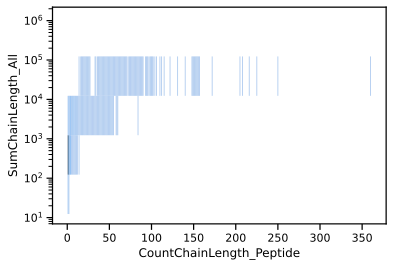

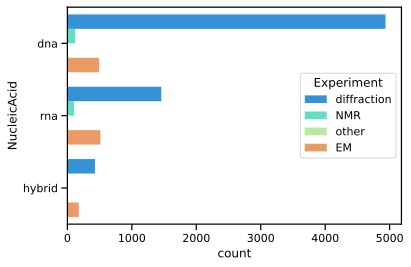

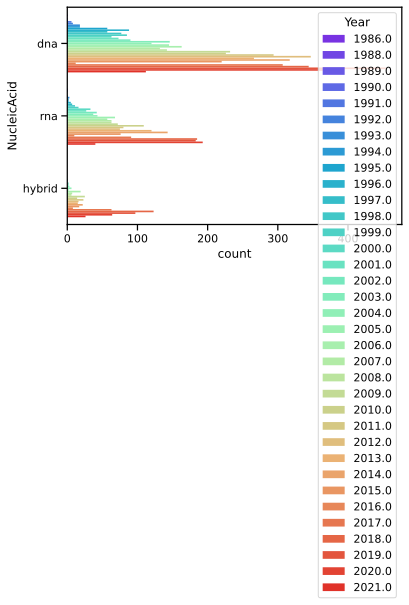

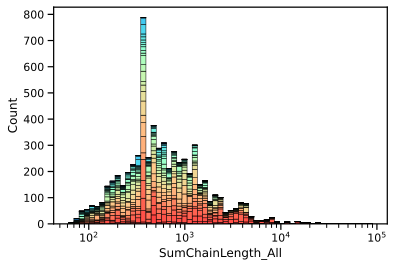

In [9]:
# =============== Some Descriptive stats
%config InlineBackend.figure_format = 'svg'
sns.set_context("notebook")
sns.histplot(
    Df_grandpronuc, x="CountChainLength_Peptide", y="SumChainLength_All",
    binwidth=(1,100), discrete=(True, True), log_scale=(False, True),
)
plt.show()
sns.countplot(data = Df_grandpronuc, y="NucleicAcid", hue = "Experiment", palette='rainbow')
plt.show()
sns.countplot(data = Df_grandpronuc, y="NucleicAcid", hue = "Year", palette='rainbow')
plt.show()
sns.histplot(data=Df_grandpronuc_selected, x="SumChainLength_All", hue="Year", 
            multiple="stack", palette='rainbow',log_scale=True, legend= False,
            fill=True)
plt.show()


## Checking External Symmetry by BC Clan

External symmetry describe situation where homologous chains are shared among different PDB entries dedicated to different bound RNA sequences, quality of resolved proteins, and mutants, etc. We will use a graph to organise the check on external symmetry among PDB entries. The graph contains two types of nodes - PDBID and BlastClust ID. We will first assign membership edge of BlastClust to individual PDB Entry - this connects PDBID to potentially many BlastClust ID(s) when the PDB entry contain multiple chains. We call the the connected components "clans". PDBID within each connected component share at least one RNA-bound chain with another PDBID, allowing perhaps some common patterns within the clan. On the other hand, disconnection means the PDB entries are not reachable in terms of protein information - a criterion for fair cross-validation. The production of this graph will take ~20 minutes for all available blast clust percentage curated by PDB. 

In [7]:
import gc
BCDict = ReadBCExternalSymmetry("../Database-PDB/DerivedData")
MmseqDict = ReadMmseqExternalSymmetry("../Database-PDB/DerivedData")
for hom_percent in [100,95,90,70,50,40,30]:
        test_G = MakeBcClanGraph(BCDict,BlastClustPercent = hom_percent, 
                            DIR_DataframeGrand_CoordSupplement ="../Database-PDB/DerivedData/DataframeGrand_CoordSupplement.pkl",
                            )

        # NOTE I commented out these two lines as it will overwrite the pkl file we provided and used to train our own models
        #      
        #with open("../Database-PDB/DerivedData/" + 'ClanGraph_%s.pkl' %(hom_percent), 'wb') as fn:
        #            pickle.dump(test_G,fn, protocol=4)


        del test_G
        gc.collect() 

        test_G = MakeMmseqClanGraph(MmseqDict,MmseqClustPercent = hom_percent, 
                            DIR_DataframeGrand_CoordSupplement ="../Database-PDB/DerivedData/DataframeGrand_CoordSupplement.pkl",
                            )
        with open("../Database-PDB/DerivedData/" + 'MmseqClanGraph_%s.pkl' %(hom_percent), 'wb') as fn:
                    pickle.dump(test_G,fn, protocol=4)
        
        del test_G
        gc.collect() 

Number of clusters in each BC percent
BC100	 102367
BC95	 71152
BC90	 66579
BC70	 57099
BC50	 48966
BC40	 44158
BC30	 38905
Making Clan Graph


100%|██████████| 102367/102367 [01:35<00:00, 1070.54it/s]


Calculating Jaccard similarity (Overlap of Pdbids) among Blast Clusters


100%|██████████| 3808/3808 [00:09<00:00, 407.50it/s] 


Calculating Jaccard similarity (Overlap of Blast Clusters) among Pdbid


100%|██████████| 7012/7012 [00:32<00:00, 218.26it/s] 


Making Clan Graph


100%|██████████| 71152/71152 [01:36<00:00, 734.26it/s] 


Calculating Jaccard similarity (Overlap of Pdbids) among Blast Clusters


100%|██████████| 2787/2787 [00:05<00:00, 512.02it/s] 


Calculating Jaccard similarity (Overlap of Blast Clusters) among Pdbid


100%|██████████| 7012/7012 [00:32<00:00, 218.71it/s] 


Making Clan Graph


100%|██████████| 66579/66579 [01:37<00:00, 684.15it/s] 


Calculating Jaccard similarity (Overlap of Pdbids) among Blast Clusters


100%|██████████| 2705/2705 [00:05<00:00, 509.46it/s] 


Calculating Jaccard similarity (Overlap of Blast Clusters) among Pdbid


100%|██████████| 7012/7012 [00:32<00:00, 214.64it/s] 


Making Clan Graph


100%|██████████| 57099/57099 [01:38<00:00, 582.27it/s] 


Calculating Jaccard similarity (Overlap of Pdbids) among Blast Clusters


100%|██████████| 2558/2558 [00:04<00:00, 531.30it/s] 


Calculating Jaccard similarity (Overlap of Blast Clusters) among Pdbid


100%|██████████| 7012/7012 [00:32<00:00, 218.37it/s] 


Making Clan Graph


100%|██████████| 48966/48966 [01:37<00:00, 504.07it/s] 


Calculating Jaccard similarity (Overlap of Pdbids) among Blast Clusters


100%|██████████| 2342/2342 [00:04<00:00, 568.64it/s] 


Calculating Jaccard similarity (Overlap of Blast Clusters) among Pdbid


100%|██████████| 7012/7012 [00:31<00:00, 219.73it/s] 


Making Clan Graph


100%|██████████| 44158/44158 [01:34<00:00, 465.42it/s] 


Calculating Jaccard similarity (Overlap of Pdbids) among Blast Clusters


100%|██████████| 2231/2231 [00:03<00:00, 582.96it/s] 


Calculating Jaccard similarity (Overlap of Blast Clusters) among Pdbid


100%|██████████| 7012/7012 [00:32<00:00, 212.80it/s]


Making Clan Graph


100%|██████████| 38905/38905 [01:35<00:00, 407.58it/s] 


Calculating Jaccard similarity (Overlap of Pdbids) among Blast Clusters


100%|██████████| 2128/2128 [00:03<00:00, 611.72it/s] 


Calculating Jaccard similarity (Overlap of Blast Clusters) among Pdbid


100%|██████████| 7012/7012 [00:32<00:00, 216.70it/s] 


## Information Coverage (Optional)

Indeed, we also studied the relation among PDB entries and among Blast Clusters. This is done by assigning two new types of edges.

* PDB Edges. Two PDB entries are joined with an edge when at least one similar (by definition of [Blast](https://www.ncbi.nlm.nih.gov/proteinclusters/faq/)) RNA-bound protein chain among them. We will use the weight of the edge to indicate the jaccard similarity in compositional content. 
* BC Edges. We will also join Blast Clusters similarly.

Note that discarding the BlastClust nodes will now return the same connected component as before and we are particularly interested in seeing cliques in this subgraph. A maximal clique is a clique that cannot be extended by including one more adjacent vertex. A maximal clique in a clan of PDB entries implies that particular complete subgraph contains PDB entries which all share some RNA-bound chain(s) in common, pattern recognition maybe easier within the clan. Two properties of interest


* Distribution of sizes for maximal clique in each Clan. The size of maximal clique containing each PDB entry tells if the PDB entry is a hub for learning, usually, an entry comprising a biological assembly of smaller proteins observed by other researchers. The distribution of sizes tells us how many samples we can learn from. For example, singleton means there is only one example!
* Mean Percentage vertex covered by maximal clique in each clan. This tells how common can we find a learning hub in a clan.

While we have perfectly (embarrassingly) parallelised the [search for sizes of max-clique](https://networkx.org/documentation/stable/_modules/networkx/algorithms/clique.html#node_clique_number) in each connected component, the max-clique problem is NP-hard and it uses the [Bron Kerbosch algorithm](https://en.wikipedia.org/wiki/Bron–Kerbosch_algorithm) which is exponential to number of nodes in time complexity; the process can take more than 2 hours to complete. Note that a pseudo-polynomial search maybe achieved with a binary search for [cliques of fixed sizes](https://en.wikipedia.org/wiki/Clique_problem#Cliques_of_fixed_size). 

In [ ]:

from NucleicNet.DatasetBuilding.commandReadPdbFtp import GetMaxCliqueSize

for hom_percent in [100,95,90,70,50,40,30]:
    print(hom_percent)
    df_maxclique = GetMaxCliqueSize(DIR_DerivedData = "../Database-PDB/DerivedData/", bc_percent = hom_percent)
    # NOTE I commented out these two lines as it will overwrite the pkl file we provided and used to train our own models
    #df_maxclique.to_pickle("../Database-PDB/DerivedData/" + 'ClanGraph_%s_Stat.pkl' %(bc_percent), 
    #                        compression='infer', protocol=4, storage_options=None)

    del df_maxclique
    gc.collect()
    df_maxclique = MmseqGetMaxCliqueSize(DIR_DerivedData = "../Database-PDB/DerivedData/", Mmseq_percent = hom_percent)
    # NOTE I commented out these two lines as it will overwrite the pkl file we provided and used to train our own models
    df_maxclique.to_pickle("../Database-PDB/DerivedData/" + 'MmseqClanGraph_%s_Stat.pkl' %(hom_percent), 
                            compression='infer', protocol=4, storage_options=None)

    del df_maxclique
    gc.collect()

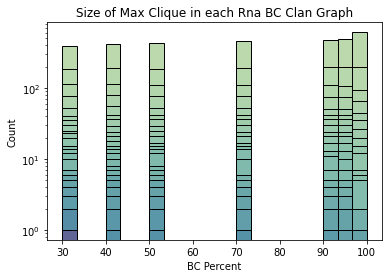

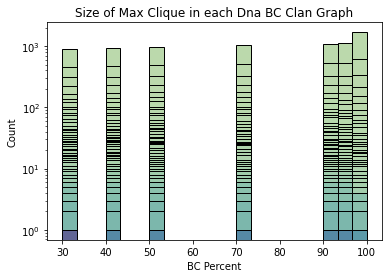

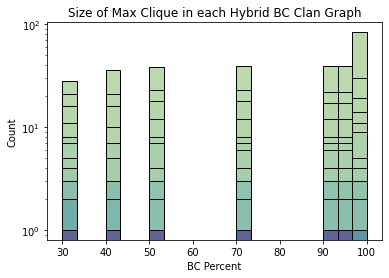

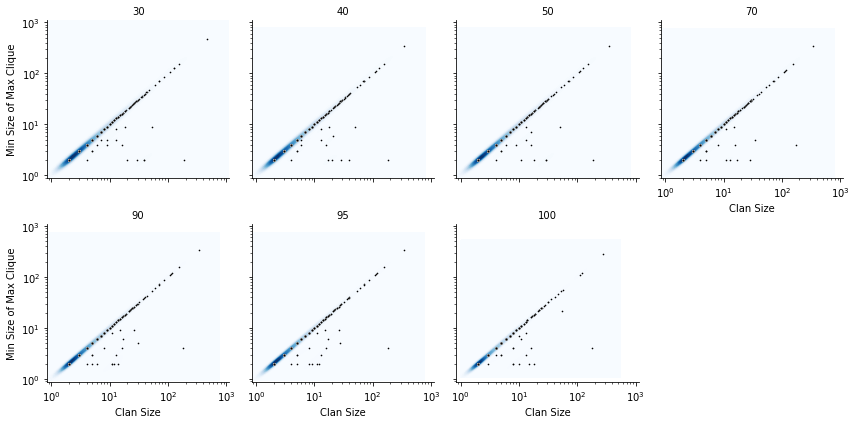

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


User_PlotMmseq = False
if User_PlotMmseq:
    FileKeyword = 'Mmseq'
    HomseqKeyword = 'Mmseq'
else:
    FileKeyword = ''
    HomseqKeyword = 'BC'


# =======================
# Plotting the graphs
# =======================
granddf_maxclique = []
for i in [100,95,90,70,50,40,30]:
    df_maxclique = pd.read_pickle("../Database-PDB/DerivedData/" + '%sClanGraph_%s_Stat.pkl' %(FileKeyword,i))
    granddf_maxclique.append(df_maxclique)
granddf_maxclique = pd.concat(granddf_maxclique, ignore_index=True)
granddf_maxclique['Dominant Nucleic Acid'] = granddf_maxclique[['Dna','Rna', "Hybrid"]].idxmax(axis=1)

# ==========================
# Size of Max Clique
# ==========================
for i in ['Rna', 'Dna', 'Hybrid']:
    local_df = granddf_maxclique.loc[granddf_maxclique['Dominant Nucleic Acid'] == i]
    g = sns.histplot(data=local_df, x="%s Percent" %(HomseqKeyword), hue="Max Size of Max Clique", multiple='stack',
                hue_order = list(range(granddf_maxclique["Max Size of Max Clique"].max()))[::-1],
                palette='crest',log_scale=False, legend= False, bins = 21,
                fill=True)
    g.set_yscale('log')
    g.set_title("Size of Max Clique in each %s %s Clan Graph" %(i, HomseqKeyword))

    plt.show()

# ===========================
# Clan Size vs Max Clique Size
# ===========================
# NOTE Excluded the singletons
g = sns.FacetGrid(granddf_maxclique.loc[granddf_maxclique['Clan Size'] > 1], 
                col="%s Percent" %(HomseqKeyword),  height=3, col_wrap=4, 
                #col = "Dominant Nucleic Acid"

                )
g.map(sns.kdeplot,  'Clan Size',"Min Size of Max Clique", fill=True, 
                cmap="Blues", levels = 50, log_scale = (10,10), thresh = None)

g.map(sns.scatterplot,   'Clan Size',"Min Size of Max Clique",  s =3, color='k')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
plt.show()

## Visualising Clans (Optional)

We will also draw a graph to illustrate overlaps of contents among PDB Entries and among Blast Clusts. As our two subjects are "almost-complete" with lots of overlap, we will call the two-pi algorithm.  In general, graph visualisation is a difficult problem as different users are burdened by different goals. 


A nice paragraph from [networkx developers](https://networkx.org/documentation/stable/reference/drawing.html)

> Proper graph visualization is hard, and we highly recommend that people visualize their graphs with tools dedicated to that task. Notable examples of dedicated and fully-featured graph visualization tools are Cytoscape, Gephi, Graphviz and, for LaTeX typesetting, PGF/TikZ. To use these and other such tools, you should export your NetworkX graph into a format that can be read by those tools. For example, Cytoscape can read the GraphML format, and so, networkx.write_graphml(G, path) might be an appropriate choice.

However, if you thought of (or could implement on jupyter) better ways to illustrate the subjects, feel free to drop an issue! Below are Visualisation of Blast Clans

In [ ]:
import networkx as nx
import plotly.graph_objects as go


User_PlotMmseq = False
if User_PlotMmseq:
    FileKeyword = 'Mmseq'
    HomseqKeyword = 'Mmseq'
else:
    FileKeyword = ''
    HomseqKeyword = 'BC'


bc_percent = 90
with open("../Database-PDB/DerivedData/" + '%sClanGraph_%s.pkl' %(FileKeyword, bc_percent), 'rb') as fn:
    test_G = pickle.load(fn)

test_G_BC = test_G.subgraph([i for i in test_G.nodes if type(i) is int])
test_G_pdbid = test_G.subgraph([i for i in test_G.nodes if type(i) is str])

# Slow for large graphs
#pos_kamada = nx.drawing.layout.kamada_kawai_layout(test_G)
#pos_circo = nx.nx_agraph.graphviz_layout(test_G, prog="circo")

# Circular not useful here
#pos_shell =  nx.drawing.layout.shell_layout(test_G, nlist=None, rotate=None, scale=1, center=None, dim=2)

# Good for large graphs
pos_sfdp =  nx.nx_agraph.graphviz_layout(test_G, prog="sfdp")
pos_neato = nx.nx_agraph.graphviz_layout(test_G, prog="neato")
pos_twopi = nx.nx_agraph.graphviz_layout(test_G, prog="twopi")

DrawNxGraphPlotly(test_G_pdbid, pos_neato, VisualiseEdge = True)

# Epilogue

Clearly, the PDB expanded a lot on RNA-bound structures in the past five years. DNA-bound/hybrid structures could be a great resource for future training - there has been much more DNA-bound than RNA-bound structures; in that case, base and phosphate overlap, but not the sugar. However, cautions has to be taken when considering which PDB entries to be included in the DNA-bound structures, as it is hard to define what is [Out-of-Distribution](https://ai.googleblog.com/2019/12/improving-out-of-distribution-detection.html) in real-world dataset (the major question is what variables we should look for in that "distribution". Self supervision is another story.). Often, these decision will require domain knowledge i.e. actually reading into the papers for provenance and prudence in dataset construction. A very real example that applies here are the existance of [non-sequence-specific shape-dependent D/RNA-binding](https://www.embopress.org/doi/full/10.1038/sj.embor.7400325), where the protein only recognise the shape outlined by the D/RNA but not their sequence. This phenomena may be reconciled by the fact that when the bases are largely enveloped by backbone e.g. in double helices, a disproportionate majority of the protein-nucleotide interaction are due to the phospho-sugar backbone, where ionic interactions cancel out the slightest base-dependent interaction deficiencies. In some cases, the specificities cannot be determined by structure alone even when the base is literally in touch with protein residues (e.g. aromatic stacking), but may be (often) indicated by the paper accompanying the structure determined. Therefore, careful curation has to be done right. 